# Visualize Filters and Feature Maps

## Imports

In [1]:
import keras
import tensorflow as tf
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

## Load Model / Data

In [2]:
model = keras.models.load_model("./data/trained_models/best.h5")

In [4]:
for layer in model.layers:

    if 'conv' not in layer.name:
        continue
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

conv2d_5 (3, 3, 1, 64)
conv2d_6 (3, 3, 64, 64)
conv2d_7 (3, 3, 64, 128)
conv2d_8 (3, 3, 128, 128)
conv2d_9 (3, 3, 128, 256)


In [4]:
# Load the CSV file into a Pandas DataFrame
file = './data/testManipulation.csv'
testimages = pd.read_csv(file)

# Convert the DataFrame to a NumPy array and normalize the values
x_testimage = testimages.values
x = x_testimage / 255.0

# Reshape the array into a 4D tensor
x = x.reshape(-1,28,28,1)

# Print the shape of the array
print(f'Data shape is: {x.shape}')

Data shape is: (21, 28, 28, 1)


In [5]:
index_of_image = 0

input_img = x[index_of_image]
input_image = x[index_of_image]

## Visualize Filter

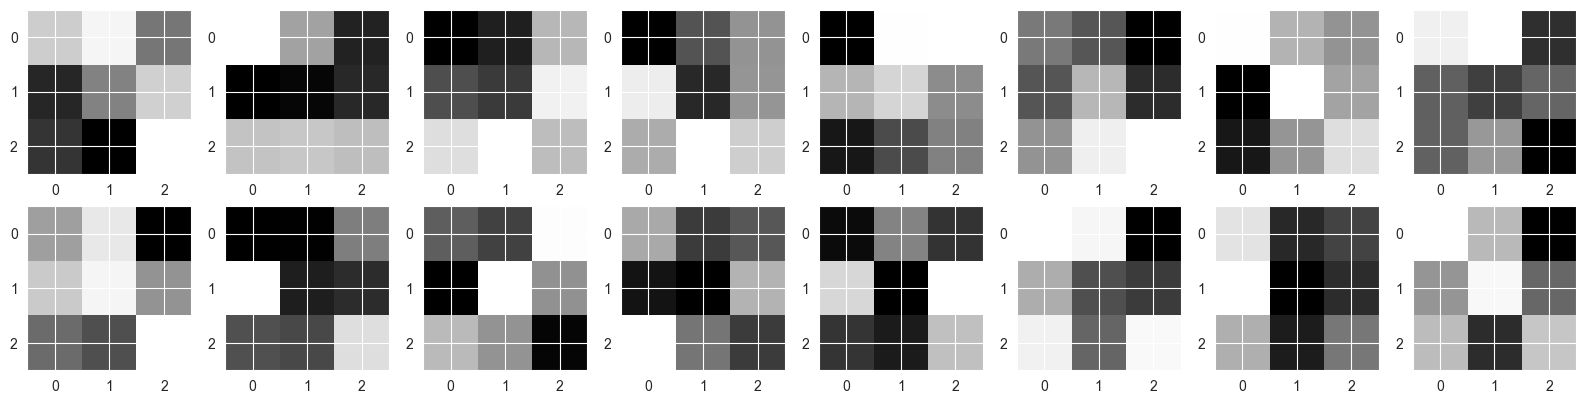

In [11]:
# Extract the weights of the first convolutional layer
weights, biases = model.layers[1].get_weights()

# Get the number of filters
n_filters = weights.shape[3]

# Set the figure size
plt.figure(figsize=(20, 20))

# Plot the filters
for i in range(16):  #n_filters to display all
    plt.subplot(8, 8, i+1)
    plt.imshow(weights[:,:,0,i], cmap="gray")
    plt.axis("on")

# Show the plot
plt.show()

## Visualize Feature Maps

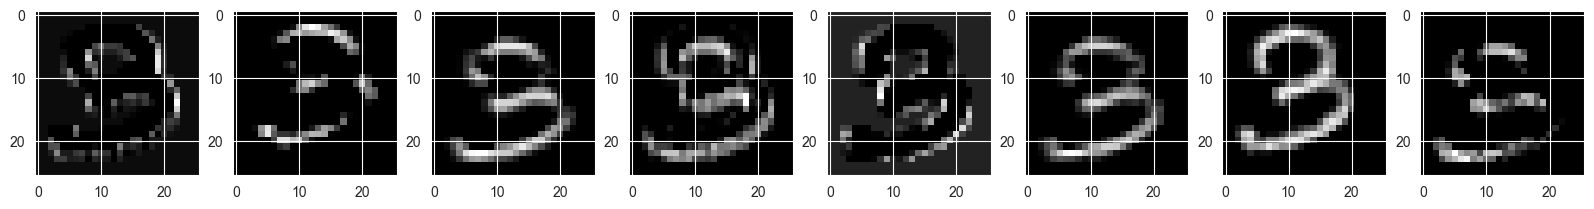

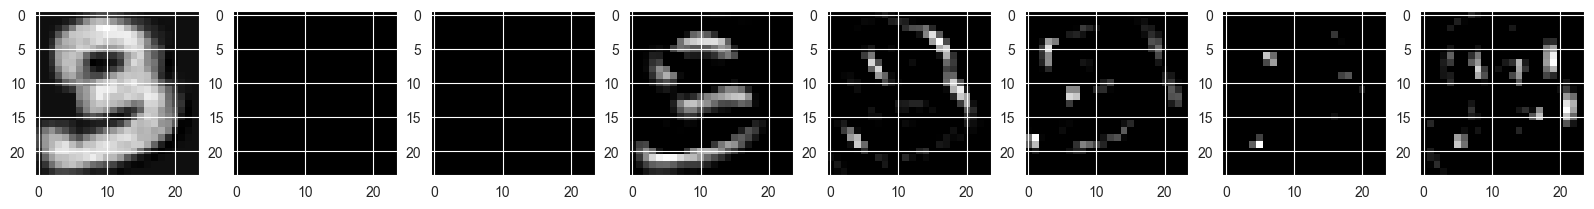

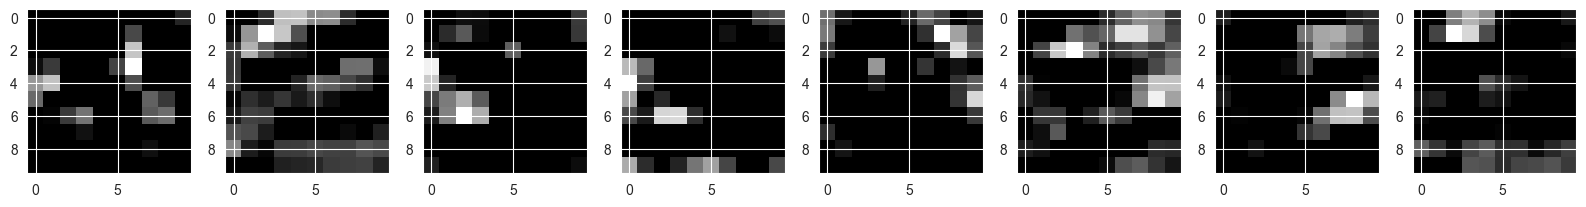

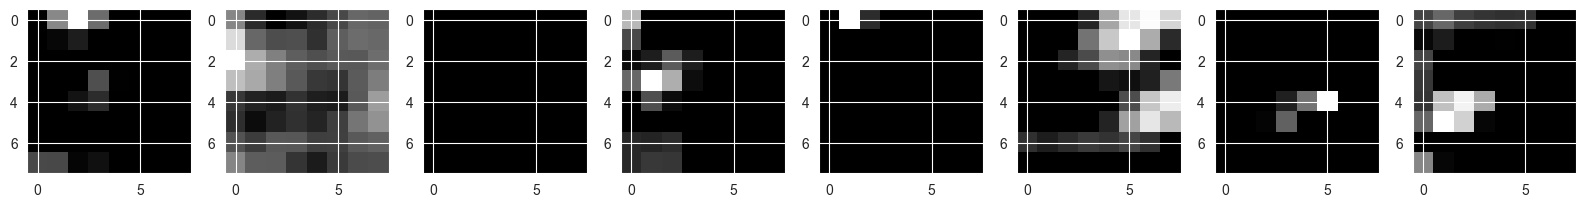

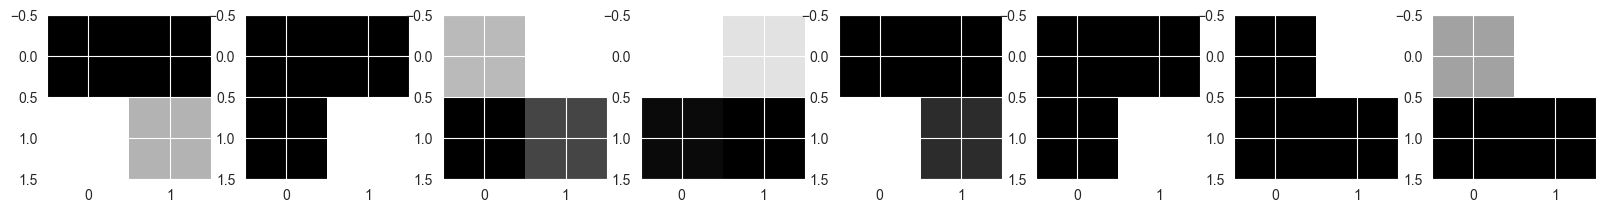

In [8]:
input_img = input_img.reshape(1, 28, 28, 1)

for i, layer in enumerate(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        # Get the output tensor of the current layer
        output_tensor = layer.output

        # Create a function that generates the feature maps
        get_feature_maps = tf.keras.backend.function([model.input], [output_tensor])

        # Generate the feature maps for the input image
        feature_maps = get_feature_maps([input_img])[0]

        # Get the number of filters
        n_filters = feature_maps.shape[3]

        # Set the figure size
        plt.figure(figsize=(20, 20))

        # Plot the feature maps
        for i in range(8):
            plt.subplot(8, 8, i+1)
            plt.imshow(feature_maps[0, :, :, i], cmap="gray")
            plt.axis("on")

        # Show the plot
        plt.show()


# Special Visualization

## SmoothGrad Visualization

In [12]:
def plot_smoothgrad_of_a_model(model, X, image_titles):
    score = CategoricalScore(list(range(X.shape[2])))

    saliency = Saliency(model, model_modifier=ReplaceToLinear(), clone=True)

    saliency_map = saliency(score, X, smooth_samples=20, smooth_noise=0.20)

    f, ax = plt.subplots(figsize=(12, 4))
    for i, title in enumerate(image_titles):
        ax.set_title(title, fontsize=16)
        ax.imshow(saliency_map[i], cmap='jet')
        ax.axis('on')
    plt.tight_layout()
    plt.show()

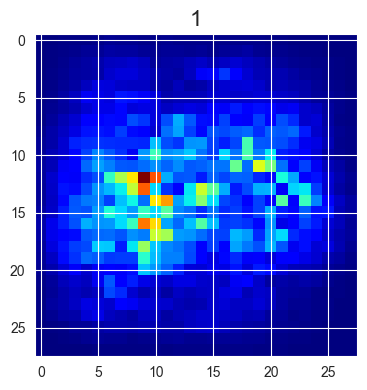

In [13]:
plot_smoothgrad_of_a_model(model, input_image, "1")

# TESTING AREA BELOW

In [408]:
# def plot_smoothgrad_of_a_model(model, X, image_titles):
#     score = CategoricalScore(list(range(X.shape[2])))
#
#     # Create Saliency visualization object
#     saliency = Saliency(model,
#                         model_modifier=ReplaceToLinear(),
#                         clone=True)
#
#     # Generate saliency map
#     saliency_map = saliency(score, X,
#                             smooth_samples=20, # The number of calculating gradients iterations
#                             smooth_noise=0.20) # noise spread level
#
#     # Render
#     f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
#     for i, title in enumerate(image_titles):
#         ax[i].set_title(title, fontsize=16)
#         ax[i].imshow(saliency_map[i], cmap='jet')
#         ax[i].axis('on')
#     plt.tight_layout()
#     plt.show()


## GradCam visualization

In [14]:
def plot_gradcam_of_a_model(model, X, image_titles, images):
    score = CategoricalScore(list(range(X.shape[2])))

    # Create Gradcam visualization object
    gradcam = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)

    # Generate heatmap by GradCAM
    cam = gradcam(score, X, penultimate_layer=-1)

    # Plot
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    for i, title in enumerate(image_titles):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        ax[i].set_title(title, fontsize=16)
        ax[i].imshow(images[i])
        ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        ax[i].axis('on')
    plt.tight_layout()
    plt.show()

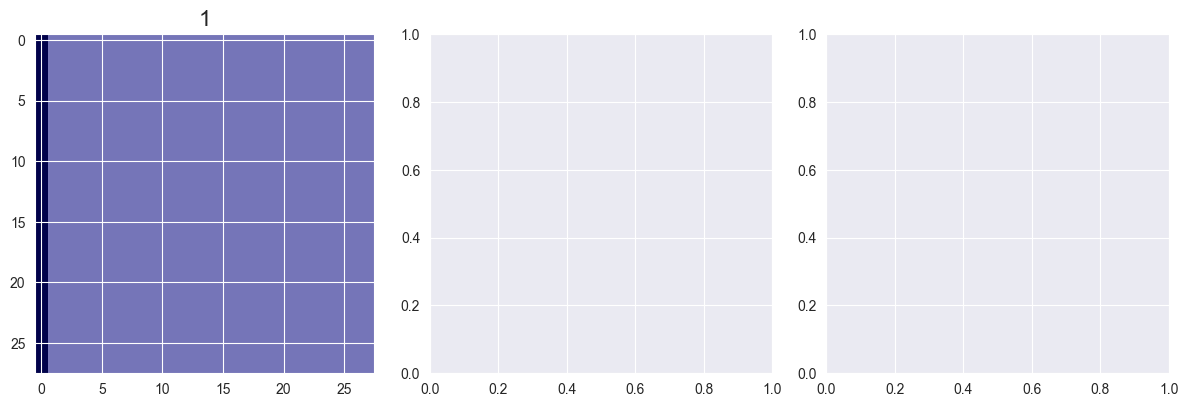

In [15]:
plot_gradcam_of_a_model(model, input_image, "1", input_image)

8/8 [==============================] - 0s 19ms/step


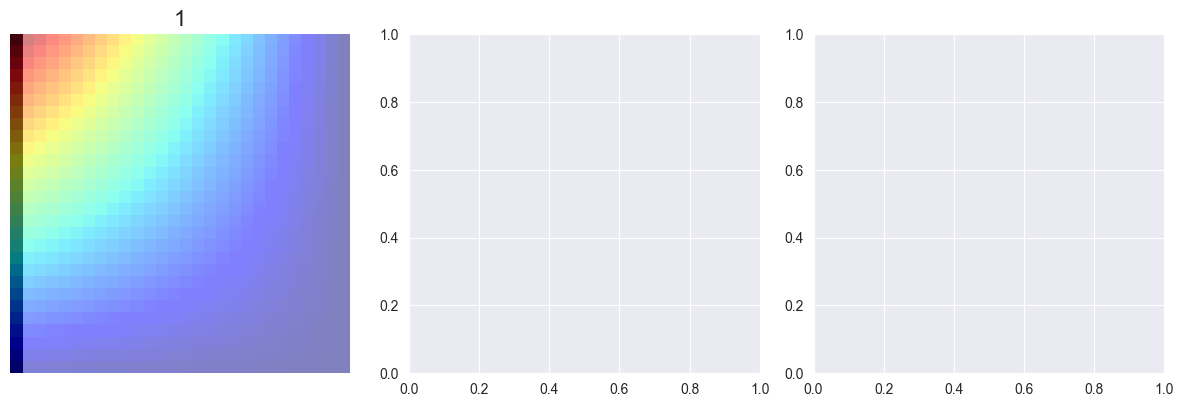

In [16]:
def plot_scorecam_of_a_model(model, X, image_titles, images):
    score = CategoricalScore(list(range(X.shape[2])))
    # Create ScoreCAM visualization object
    scorecam = Scorecam(model, model_modifier=ReplaceToLinear())

    # Generate heatmap with ScoreCAM
    cam = scorecam(score, X, penultimate_layer=-1)

    # Plot
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    for i, title in enumerate(image_titles):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        ax[i].set_title(title, fontsize=16)
        ax[i].imshow(images[i])
        ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

plot_scorecam_of_a_model(model, input_image, "1", x[0])